#### Gradient inference with functional observations in gpytorch (classification example)

In this notebook, we demonstrate the inference of gradient (marginal effect) from functional observations for classfication problem. We focus on the case 2-dimensional regressors with number of labels C=3.

In [1]:
# LOAD PACKAGES
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.models.exact_prediction_strategies import prediction_strategy
from gpytorch.means.mean import Mean
from gpytorch.kernels.kernel import Kernel
from gpytorch.lazy import InterpolatedLazyTensor
from gpytorch.utils.broadcasting import _mul_broadcast_shape
from sklearn.gaussian_process.kernels import RBF
from numpy.random import multivariate_normal

Set up data n = 500, D = 2 with c = 0,1,2

$x_{i}\in \mathbb{R}^D$ 

$f_i = \sum\limits_{d=1}^D x_{i} $

$p(y_{i}=c) = \sigma(f_i-\theta_{c+1})-\sigma(f_i-\theta_{c}), \theta=[-\infty,-2,2,\infty]$

In [107]:
def gen_prob(x,y):
    y_prob = torch.zeros((3,))
    ts = [-2,2]
    tmp = torch.zeros((2,))
    for i in range(2):
        tmp[i] = 1/(1+torch.exp((x+y)/1-ts[i]))
    y_prob[0] = tmp[0]
    y_prob[1] = tmp[1] - tmp[0]
    y_prob[2] = 1 - tmp[1]
    return y_prob

In [108]:
# define data
D = 2
n = 500
C = 3
torch.random.manual_seed(12345)
soboleng = torch.quasirandom.SobolEngine(dimension=D)
train_x = 4*soboleng.draw(n)-2
train_y = torch.zeros(n,)

y_prob = torch.zeros((n,C))
for i in range(n):
    y_prob[i,:] = gen_prob(train_x[i,0], train_x[i,1])
    train_y[i] = y_prob[i,:].multinomial(1)

train_y = train_y.long()


visualize data

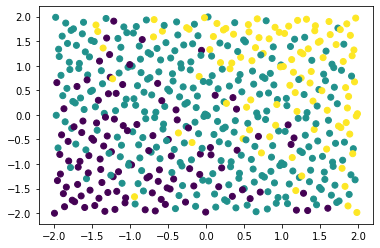

In [109]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

plot heatmap of true density of each label

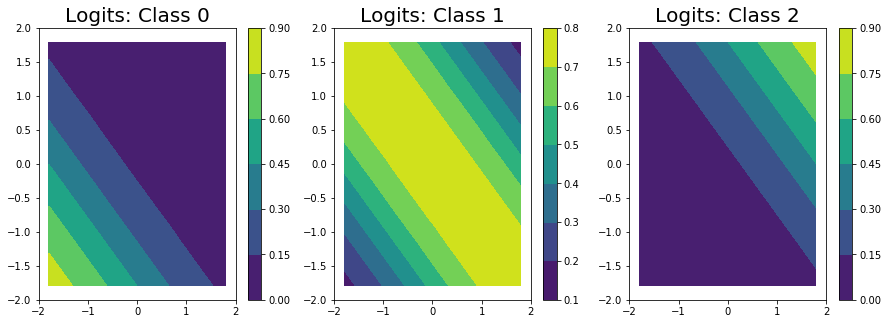

In [110]:
from scipy import interpolate
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    ndpol = interpolate.LinearNDInterpolator(train_x, y_prob[:,i])

    # Create meshgrid:
    xl = np.linspace(-2, 2, 20)
    X, Y = np.meshgrid(xl, xl)
    lims = [xl.min(), xl.max(), xl.min(), xl.max()]

    # Interpolate over meshgrid:
    V = ndpol(list(zip(X.ravel(),Y.ravel()))).reshape(X.shape)

    im = ax[i].contourf(X, Y, V)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)


define a Dirichlet GP model for classification

In [229]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
        self.N = train_x.shape[0]
        self.D = train_x.shape[1]

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def get_L_lower(self):
        """Get Cholesky decomposition L, where L is a lower triangular matrix.
        Returns:
            Cholesky decomposition L.
        """
        return (
            self.prediction_strategy.lik_train_train_covar.root_decomposition()
            .root.evaluate()
            .detach()
        )

    def get_KXX_inv(self, label):
        """Get the inverse matrix of K(X,X).
        Args:
            label: target label
        Returns:
            The inverse of K(X,X).
        """
        L_inv_upper = self.prediction_strategy.covar_cache.detach()[label]
        
        return L_inv_upper @ L_inv_upper.transpose(0, 1)

    def _get_KxX_dx(self, x, label):
        """Computes the analytic derivative of the kernel K(x,X) w.r.t. x.
        Args:
            x: (n x D) Test points.
            label: target label
        Returns:
            (n x D) The derivative of K(x,X) w.r.t. x.
        """
        X = self.train_inputs[0]
        n = x.shape[0]
        K_xX = self.covar_module(x, X).evaluate()[label].reshape(n, self.N)
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()[label]
        return ( -torch.eye(self.D, device=x.device) / lengthscale ** 2 @
            (
                (x.view(n, 1, self.D) - X.view(1, self.N, self.D))
                * K_xX.view(n, self.N, 1)
            ).transpose(1, 2) 
        )

    def _get_Kxx_dx2(self, label):
        """Computes the analytic second derivative of the kernel K(x,x) w.r.t. x.
        Args:
            x: (n x D) Test points.
            label: target label
        Returns:
            (n x D x D) The second derivative of K(x,x) w.r.t. x.
        """
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()[label]
        sigma_f = self.covar_module.outputscale.detach()[label]
        return (
            torch.eye(self.D, device=lengthscale.device) / lengthscale ** 2
        ) * sigma_f

    def posterior_derivative(self, x, label):
        """Computes the posterior of the derivative of the GP w.r.t. the given test
        points x.
        Args:
            x: (n x D) Test points.
            label: target label
        Returns:
            A GPyTorchPosterior.
        """

        with torch.no_grad():
            if self.prediction_strategy is None:
                train_output = super().__call__(self.train_inputs)
                # Create the prediction strategy for
                self.prediction_strategy = prediction_strategy(
                    train_inputs=self.train_inputs,
                    train_prior_dist=train_output,
                    train_labels=self.train_targets,
                    likelihood=self.likelihood,
                )

            K_xX_dx = self._get_KxX_dx(x, label)
            KXX_inv = self.get_KXX_inv(label)
            mean_d = K_xX_dx @ KXX_inv @ (self.train_targets[label])
            variance_d = (
                self._get_Kxx_dx2(label) - K_xX_dx @ KXX_inv @ K_xX_dx.transpose(1, 2)
            )
            variance_d = variance_d.clamp_min(1e-8)

        return mean_d, variance_d

learn hyperparameter by minimizing the negative log likelihood using ADAM optimizer

In [230]:
# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 8.399   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 7.927   lengthscale: 0.959   noise: 0.974
Iter 11/50 - Loss: 7.678   lengthscale: 1.201   noise: 1.313
Iter 16/50 - Loss: 7.521   lengthscale: 1.390   noise: 1.690
Iter 21/50 - Loss: 7.417   lengthscale: 1.537   noise: 2.078
Iter 26/50 - Loss: 7.348   lengthscale: 1.655   noise: 2.453
Iter 31/50 - Loss: 7.304   lengthscale: 1.755   noise: 2.794
Iter 36/50 - Loss: 7.276   lengthscale: 1.843   noise: 3.093
Iter 41/50 - Loss: 7.258   lengthscale: 1.918   noise: 3.346
Iter 46/50 - Loss: 7.247   lengthscale: 1.978   noise: 3.557


plot posterior logit of latent functions

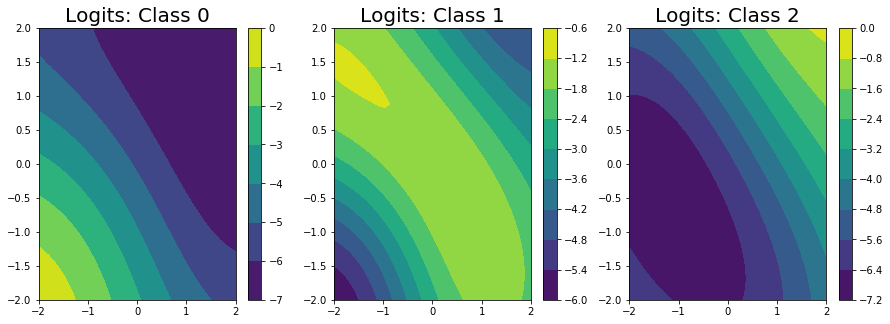

In [145]:
model.eval()
likelihood.eval()

test_d1 = np.linspace(-2, 2, 40)
test_d2 = np.linspace(-2, 2, 40)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape(test_x_mat.shape)
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

plot the posterior probability of each category by sampling from the posterior 

$$
\begin{aligned}
E[\pi_c|X] &= \int \frac{\exp(f_c)}{\sum\limits_c \exp(f_c)} p(f|X)df\\
&\approx \frac{1}{K} \sum\limits_k \frac{\exp(f^k_c)}{\sum\limits_j \exp(f^k_j)}, \quad f^k\sim p(f|X)
\end{aligned}
$$

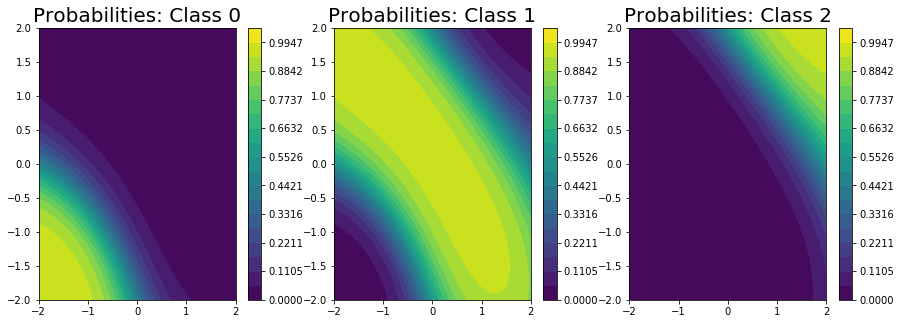

In [246]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape(test_x_mat.shape), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

plot the posterior gradient of probability of each category

$$
\begin{aligned}
\frac{\partial E[\pi_c|X]}{\partial x} &= \frac{\partial}{\partial x} \int \frac{\exp(f_c)}{\sum\limits_j \exp(f_j)} p(f|X)df\\
&\approx \frac{1}{K} \sum\limits_k \frac{\partial}{\partial x} \frac{\exp(f^k_c)}{\sum\limits_j \exp(f^k_j)}, \quad f^k\sim p(f|X)\\
&=\frac{1}{K} \sum\limits_k \sum\limits_i \frac{\partial}{\partial f_i} \frac{\exp(f^k_c)}{\sum\limits_j \exp(f^k_j)} \frac{\partial f_i}{\partial x}\\
&=\frac{1}{K} \sum\limits_k p_c (\frac{\partial f_c}{\partial x}-\sum\limits_i p_i \frac{\partial f_i}{\partial x}), \quad p_i = \frac{\exp(f^k_i)}{\sum\limits_j \exp(f^k_j)}
\end{aligned}
$$

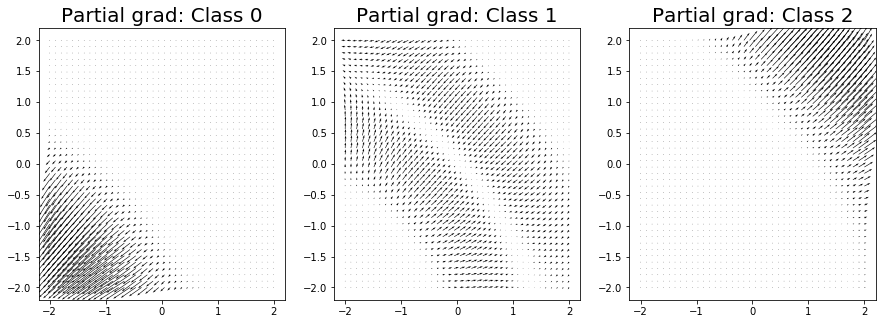

In [270]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

averaged_grad = torch.zeros((test_x.shape[0],D))

for i in range(3):
    with torch.no_grad():
        mean_d, variance_d = model.posterior_derivative(test_x,i)
    pred_grad_samples = gpytorch.distributions.MultivariateNormal(mean_d, variance_d).sample(torch.Size((256,)))
    averaged_grad -= probabilities[i].view((-1,1)) * pred_grad_samples.mean(dim=0)

for i in range(3):
    with torch.no_grad():
        mean_d, variance_d = model.posterior_derivative(test_x,i)

    pred_grad_samples = gpytorch.distributions.MultivariateNormal(mean_d, variance_d).sample(torch.Size((256,)))
    grad_probabilities = probabilities[i].view((-1,1)) * (pred_grad_samples.mean(dim=0) - averaged_grad)

    im = ax[i].quiver(
        test_x_mat.numpy(), test_y_mat.numpy(), grad_probabilities[:,0].numpy().reshape(test_x_mat.shape),\
            grad_probabilities[:,1].numpy().reshape(test_x_mat.shape)
    )
    ax[i].set_title("Partial grad: Class " + str(i), fontsize = 20)